In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU Found. Training will be fast. 🚀")
else:
    print("⚠️ No GPU detected. Training will be slow (CPU only).")


⚠️ No GPU detected. Training will be slow (CPU only).


In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
HEAD_TRAIN_EPOCHS = 10 
FINE_TUNE_EPOCHS = 15 
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE_TUNE = 5e-5 
FOLD_ID = 1

DATA_PATH = 'C:/Users/Suvha/Downloads/Compressed/BreaKHis_v1'
CSV_PATH = 'C:/Users/Suvha/Downloads/Folds.csv (1)/Folds.csv'

In [4]:
print("\n--- 1. Data Loading and Splitting ---")
df = pd.read_csv(CSV_PATH)


--- 1. Data Loading and Splitting ---


In [5]:
df

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...


In [7]:
df['filename'] = df['filename'].apply(lambda x: x.replace('BreaKHis_v1/', '', 1).replace('\\', '/'))


df['label'] = df['filename'].apply(lambda x: 0 if 'benign' in x else 1)
df['label_name'] = df['label'].apply(lambda x: 'Benign' if x == 0 else 'Malignant').astype(str)
df['mag_X'] = df['mag'].astype(str) + 'X' 



C:\Users\Suvha\AppData\Local\Temp\ipykernel_11436\1261521372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis')


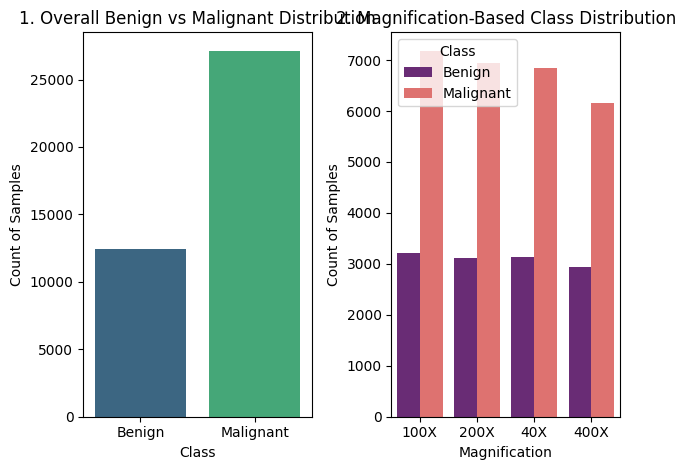

In [8]:
plt.subplot(1, 2, 1)
sns.countplot(x='label_name', data=df, palette='viridis')
plt.title('1. Overall Benign vs Malignant Distribution')
plt.xlabel('Class')
plt.ylabel('Count of Samples')


plt.subplot(1, 2, 2)
sns.countplot(x='mag_X', hue='label_name', data=df, palette='magma', hue_order=['Benign', 'Malignant'])
plt.title('2. Magnification-Based Class Distribution')
plt.xlabel('Magnification')
plt.ylabel('Count of Samples')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [9]:
df_fold = df[df['fold'] == FOLD_ID]
train_df = df_fold[df_fold['grp'] == 'train']
test_df = df_fold[df_fold['grp'] == 'test']

print(f"--- Fold {FOLD_ID} Data Summary ---")
print(f"Train Samples: {len(train_df)} | Benign: {len(train_df[train_df['label']==0])}, Malignant: {len(train_df[train_df['label']==1])}")
print(f"Test Samples: {len(test_df)} | Benign: {len(test_df[test_df['label']==0])}, Malignant: {len(test_df[test_df['label']==1])}")



--- Fold 1 Data Summary ---
Train Samples: 5005 | Benign: 1472, Malignant: 3533
Test Samples: 2904 | Benign: 1008, Malignant: 1896


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=DATA_PATH,
    x_col='filename',
    y_col='label', 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw', 
    shuffle=True,
    seed=42
)

Found 3533 validated image filenames.


C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1472 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [12]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=DATA_PATH,
    x_col='filename',
    y_col='label', 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw', 
    shuffle=False
)

Found 1896 validated image filenames.


C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1008 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [13]:
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) 
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model



In [14]:
model = create_resnet_model(IMAGE_SIZE + (3,), 1)

In [15]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), # 5 epoch অপেক্ষা করে, Loss না কমলে বন্ধ
    ModelCheckpoint('best_head_model.h5', monitor='val_auc', mode='max', save_best_only=True)
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_HEAD),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

print("\n--- 4. Training Head Layers (Phase 1) ---")


--- 4. Training Head Layers (Phase 1) ---


In [16]:
history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=HEAD_TRAIN_EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.n // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9790 - auc: 0.0000e+00 - loss: 0.0463 - precision: 1.0000 - recall: 0.9790

110/110 ━━━━━━━━━━━━━━━━━━━━ 996s 9s/step - accuracy: 0.9960 - auc: 0.0000e+00 - loss: 0.0092 - precision: 1.0000 - recall: 0.9960 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.8803e-07 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
  1/110 ━━━━━━━━━━━━━━━━━━━━ 9:10 5s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 4.4437e-07 - precision: 1.0000 - recall: 1.0000

C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


110/110 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 4.4437e-07 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.8107e-07 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 867s 8s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 1.1644e-06 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.6381e-08 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 7.8797e-07 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.6199e-08 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 853s 8s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 8.0306e-07 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 4.6211e-09 - val_precision: 1.0

In [17]:
for layer in model.layers:
    if layer.name.startswith('conv5_block'):
        layer.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

print("\n--- 5. Fine-Tuning Last Blocks (Phase 2) ---")


--- 5. Fine-Tuning Last Blocks (Phase 2) ---


In [18]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('final_best_model.h5', monitor='val_auc', mode='max', save_best_only=True)
]

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.n // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 4.7620e-06 - precision_1: 1.0000 - recall_1: 1.0000

C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


110/110 ━━━━━━━━━━━━━━━━━━━━ 1410s 13s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.8840e-06 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 3.1754e-07 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 17:55 10s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 5.2523e-08 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 5.2523e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 3.1972e-07 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.1656e-07 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 1346s 12s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 9.9233e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 8.5354e-08 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 13:26 7s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 5.7970e-08 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 5.7970e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 8.2954e-08 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 2.2673e-08 - precision_1: 1.0000 - recall_1: 1.0000 

110/110 ━━━━━━━━━━━━━━━━━━━━ 4963s 45s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.9031e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 3.3867e-09 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 6/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 23:23 13s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 2.5987e-09 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 7751s 71s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 2.5987e-09 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 3.3068e-09 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 76s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.5838e-08 - precision_1: 1.0000 - recall_1: 1.0000  

110/110 ━━━━━━━━━━━━━━━━━━━━ 9028s 83s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.5775e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 4.4797e-10 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 8/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 12:46 7s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.0195e-08 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.0195e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 4.4305e-10 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 9/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 2.7737e-08 - precision_1: 1.0000 - recall_1: 1.0000 

110/110 ━━━━━━━━━━━━━━━━━━━━ 8618s 79s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 2.0633e-08 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 1.1659e-10 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 10/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 12:36 7s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 9.3701e-10 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 9.3701e-10 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 1.1668e-10 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 11/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 6.8347e-09 - precision_1: 1.0000 - recall_1: 1.0000 

110/110 ━━━━━━━━━━━━━━━━━━━━ 5988s 55s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 8.1220e-09 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 8.7569e-11 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 12/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 13:18 7s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.5119e-09 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.5119e-09 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 8.7579e-11 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 13/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 8.5134e-09 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 1079s 10s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 7.2500e-09 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 6.9231e-11 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 14/15
  1/110 ━━━━━━━━━━━━━━━━━━━━ 13:07 7s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 6.6491e-10 - precision_1: 1.0000 - recall_1: 1.0000

110/110 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 6.6491e-10 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 6.9425e-11 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 15/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 1.2722e-08 - precision_1: 1.0000 - recall_1: 1.0000 

110/110 ━━━━━━━━━━━━━━━━━━━━ 3443s 32s/step - accuracy: 1.0000 - auc_1: 0.0000e+00 - loss: 9.1070e-09 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 0.0000e+00 - val_loss: 5.6429e-11 - val_precision_1: 1.0000 - val_recall_1: 1.0000


In [19]:
print("\n--- 6. Final Magnification-Specific Evaluation ---")
magnifications = [100, 200, 400]
results = {}

for mag in magnifications:
    mag_test_df = test_df[test_df['mag'] == mag]
    
    if len(mag_test_df) == 0:
        continue


--- 6. Final Magnification-Specific Evaluation ---


In [27]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd
import math 
mag_test_generator = test_datagen.flow_from_dataframe(
    dataframe=mag_test_df,
    directory=DATA_PATH,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 418 validated image filenames.


C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 237 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [28]:
num_samples_loaded = mag_test_generator.samples


In [29]:
y_true_full = mag_test_df['label'].values 
y_true = y_true_full[:num_samples_loaded]

In [30]:
TEST_STEPS = int(math.ceil(num_samples_loaded / BATCH_SIZE))

In [31]:
Y_pred = model.predict(
    mag_test_generator,
    steps=TEST_STEPS
)


C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step


In [32]:
print(f"Loaded Samples: {num_samples_loaded}")
print(f"y_true Length: {len(y_true)}")
print(f"Y_pred Length: {len(Y_pred)}")


y_pred_class = (Y_pred > 0.5).astype("int32")

Loaded Samples: 418
y_true Length: 418
Y_pred Length: 418


In [33]:
report = classification_report(y_true, y_pred_class, output_dict=True, zero_division=0)
auc = roc_auc_score(y_true, Y_pred)


In [35]:
results[f'{mag}X'] = {
    'F1-Score (Malignant)': report['1']['f1-score'],
    'AUC': auc,
    'Accuracy': report['accuracy'],
    'Confusion Matrix': confusion_matrix(y_true, y_pred_class).tolist()
}

In [36]:
print(f"\nResults for {mag}X Magnification:")
print(f"  Accuracy: {results[f'{mag}X']['Accuracy']:.4f}")
print(f"  F1-Score: {results[f'{mag}X']['F1-Score (Malignant)']:.4f}")
print(f"  AUC: {results[f'{mag}X']['AUC']:.4f}")

print("\n--- Summary of Magnification-Agnostic Performance ---")
print(pd.DataFrame(results).T)


Results for 400X Magnification:
  Accuracy: 0.4330
  F1-Score: 0.6043
  AUC: 0.5000

--- Summary of Magnification-Agnostic Performance ---
     F1-Score (Malignant)  AUC  Accuracy      Confusion Matrix
400X             0.604341  0.5  0.433014  [[0, 237], [0, 181]]


In [37]:
import tensorflow as tf
from tensorflow.keras.models import load_model


file_path = "C:/Users/Suvha/Documents/final_best_model.h5"

try:
    
    final_model = load_model(file_path)

    print(f"\n'{file_path}' has been loaded successfully.")

    
    final_model.summary()

except Exception as e:
    print(f"\nAn issue occurred while loading the model: {e}")



'C:/Users/Suvha/Documents/final_best_model.h5' has been loaded successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,515 (91.98 MB)

 Trainable params: 15,500,801 (59.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

 Optimizer params: 2 (12.00 B)